In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:6


In [2]:
from bliss import sleep
from bliss.datasets import simulated

In [3]:
import sys
sys.path.append('../starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import daophot_utils
import utils

In [4]:
%matplotlib inline

# load data

In [5]:
from astropy.io import fits
hdul = fits.open('./data/decaps_l0_b0_hdu08_i')

image = torch.Tensor(hdul[1].data).unsqueeze(0).unsqueeze(0)

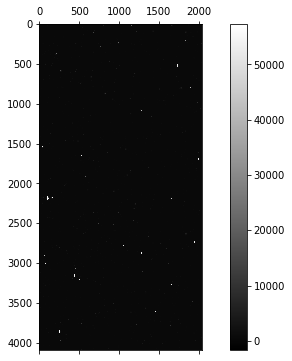

In [6]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

im = plotting.plot_image(ax, image[0, 0])

f.colorbar(im, ax = ax)

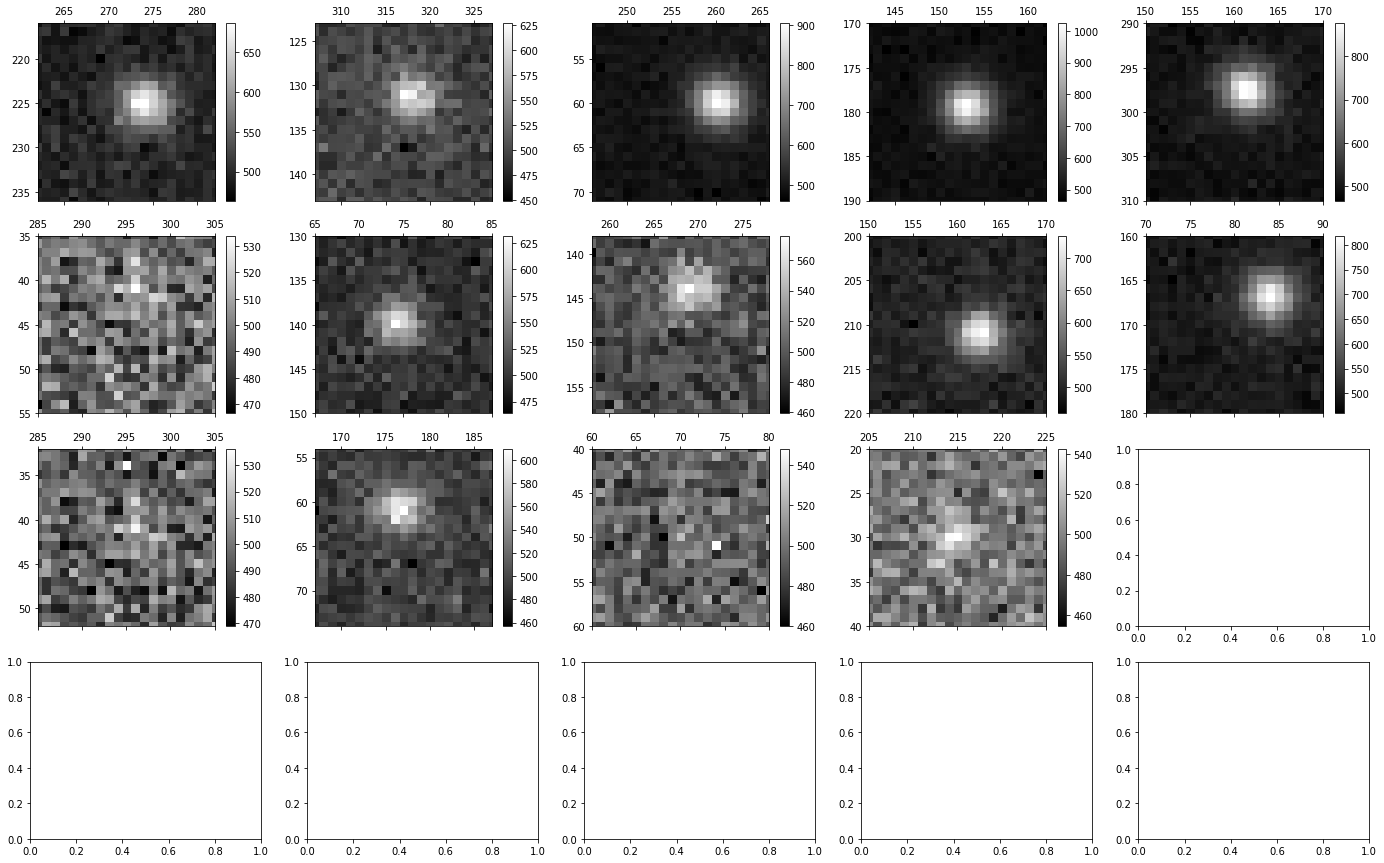

In [10]:
f, axarr = plt.subplots(4, 5, figsize=(24, 15))

subimage_slen = 20
# x1_vec = np.array([252, 297, 236, 285, 132, 140, 210, 280, 160, 37, 80, 275, 55, 248, 270, 140, 60, 280, 90, 180]) + 10
# x0_vec = np.array([216, 123, 51, 180, 170, 290, 270, 160, 250, 75, 40, 35, 130, 138, 255, 200, 160, 160, 20, 165])

x0_vec = np.array([216, 123, 51, 170, 290, 35, 130, 138, 200, 160, 32, 54, 40, 20]) 
x1_vec = np.array([252, 297, 236, 132, 140, 275, 55, 248, 140, 60, 275, 157, 50, 195]) + 10

for i in range(len(x0_vec)): 
    _x0 = x0_vec[i]
    _x1 = x1_vec[i]
    
    ax = axarr[i // 5,  i % 5]
    
        
    im = plotting.plot_image(ax, 
                             image[0, 0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)

In [11]:
psf_test_images = torch.zeros(len(x0_vec), 
                              image.shape[1],
                              subimage_slen, 
                              subimage_slen)

for i in range(len(x0_vec)): 
    _x0 = x0_vec[i]
    _x1 = x1_vec[i]
    
    psf_test_images[i] = image[0, :, _x0:(_x0+subimage_slen), _x1:(_x1+subimage_slen)]

In [12]:
from torch import nn
from torch import optim
from torch.distributions import Normal

from bliss.models import decoder

In [13]:
class CatalogParams(nn.Module):
    def __init__(self, n_bands = 1, n_images = 10): 
        
        super(CatalogParams, self).__init__()
                
        self.n_bands = n_bands
        self.n_images = n_images
        
        logit_locs = torch.zeros((n_images, 1, 2))
        log_fluxes = torch.zeros((n_images, 1, n_bands)) + np.log(1000)
        log_back = torch.Tensor([np.log(670.)])
        
        
        self.logit_loc_params = nn.Parameter(logit_locs.clone(), requires_grad=True)
        self.log_flux_params = nn.Parameter(log_fluxes.clone(), requires_grad=True)
        self.log_back_params = nn.Parameter(log_back.clone(), requires_grad=True)
        
    def forward(self): 
        
        locs = torch.sigmoid(self.logit_loc_params)
        fluxes = torch.exp(self.log_flux_params)
        sky_back = torch.exp(self.log_back_params)
        
        return locs, fluxes, sky_back

In [14]:
tile_slen = 20
n_bands = 1
psf_slen = 51
# psf_params_file = './psf/zband_psf_gauss.npy'
psf_params_file = './psf/iband_psf_init.npy'
                    
tiler = decoder.Tiler(tile_slen, tile_slen)

star_decoder = decoder.StarTileDecoder(tiler, 
                                       n_bands = n_bands, 
                                       psf_slen = psf_slen, 
                                       psf_params_file = psf_params_file)


In [15]:
catalog_params = CatalogParams(n_images = psf_test_images.shape[0])

In [16]:
def get_loss(images,
             catalog_params,
             star_decoder,
             sky_back = 670, 
             detach_psf = True): 
    
    # get catalog
    locs, fluxes, sky_back = catalog_params()
    star_bool = torch.ones((images.shape[0], 1, 1))
    
    # get reconstruction
    recon_mean = star_decoder.forward(locs, fluxes, star_bool, detach_psf) + sky_back

    normal = Normal(loc=recon_mean, scale=torch.sqrt(recon_mean))

    return -normal.log_prob(images).mean(), recon_mean


In [17]:
def run_lbfgs(images,
              optim_parameters,
              detach_psf, 
              lr = 1, 
              max_outer_iter=10, 
              max_inner_iter=50,
              tol=1e-8,
              print_every=True): 
    
    optimizer = optim.LBFGS(
        optim_parameters,
        max_iter=max_inner_iter,
        line_search_fn="strong_wolfe",
        lr = lr
    )

    def closure():
        optimizer.zero_grad()
        loss = get_loss(images, 
                        catalog_params,
                        star_decoder, 
                        detach_psf = detach_psf)[0]
        
        loss.backward()

        return loss

    init_loss = closure()

    old_loss = 1e16
    for i in range(max_outer_iter):
        loss = optimizer.step(closure)

        if print_every:
            print(loss)

        diff = (loss - old_loss).abs()
        if diff < (tol * init_loss.abs()):
            break

        old_loss = loss
    
    return loss

In [18]:
for p in star_decoder.parameters(): 
    print(p)

Parameter containing:
tensor([[ 1.3156,  2.0087,  0.0000,  0.0000, -0.6931, -0.6931]],
       dtype=torch.float64, requires_grad=True)


In [19]:
old_loss = 1e16
tol = 1e-5

for i in range(1000): 
    print('#### optimizing catalog')
    _ = run_lbfgs(psf_test_images, 
              catalog_params.parameters(), 
              lr = 1e-2,
              detach_psf = True)
    
    print('#### optimizing psf')
    loss = run_lbfgs(psf_test_images, 
              star_decoder.parameters(), 
              detach_psf = False)
    
    diff = (loss - old_loss).abs()
    if diff < tol: 
        break
    
    old_loss = loss
    
print('done')

#### optimizing catalog
tensor(25.6394, grad_fn=<NegBackward>)
tensor(5.6693, grad_fn=<NegBackward>)
tensor(5.5753, grad_fn=<NegBackward>)
tensor(5.0093, grad_fn=<NegBackward>)
tensor(4.6839, grad_fn=<NegBackward>)
tensor(4.3167, grad_fn=<NegBackward>)
tensor(4.2166, grad_fn=<NegBackward>)
tensor(4.2066, grad_fn=<NegBackward>)
tensor(4.2023, grad_fn=<NegBackward>)
tensor(4.2019, grad_fn=<NegBackward>)
#### optimizing psf
tensor(4.2004, grad_fn=<NegBackward>)
tensor(4.1819, grad_fn=<NegBackward>)
tensor(4.1819, grad_fn=<NegBackward>)
#### optimizing catalog
tensor(4.1819, grad_fn=<NegBackward>)
tensor(4.1785, grad_fn=<NegBackward>)
tensor(4.1785, grad_fn=<NegBackward>)
#### optimizing psf
tensor(4.1785, grad_fn=<NegBackward>)
tensor(4.1768, grad_fn=<NegBackward>)
tensor(4.1768, grad_fn=<NegBackward>)
#### optimizing catalog
tensor(4.1768, grad_fn=<NegBackward>)
tensor(4.1760, grad_fn=<NegBackward>)
tensor(4.1760, grad_fn=<NegBackward>)
#### optimizing psf
tensor(4.1760, grad_fn=<NegBack

In [20]:
for p in star_decoder.parameters(): 
    print(p)

Parameter containing:
tensor([[ 1.2235,  1.2471,  2.4530,  1.8599, -1.2197, -1.8916]],
       dtype=torch.float64, requires_grad=True)


In [21]:
# this is the estimated sky background
catalog_params()[2]

tensor([493.4746], grad_fn=<ExpBackward>)

In [22]:
est_locs = catalog_params()[0].squeeze().cpu().detach().numpy()

In [23]:
recon_mean = get_loss(psf_test_images, catalog_params, star_decoder)[1].detach()

In [24]:
est_locs

array([[0.47930148, 0.6268556 ],
       [0.43723172, 0.57349116],
       [0.46829098, 0.73910576],
       [0.49649072, 0.5814812 ],
       [0.39973316, 0.59251124],
       [0.34904578, 0.59652215],
       [0.51674247, 0.49116424],
       [0.3250709 , 0.583879  ],
       [0.5771868 , 0.65029943],
       [0.3706851 , 0.724278  ],
       [0.47782916, 0.59391725],
       [0.36659092, 0.50207007],
       [0.50150067, 0.59226847],
       [0.5240956 , 0.49568254]], dtype=float32)

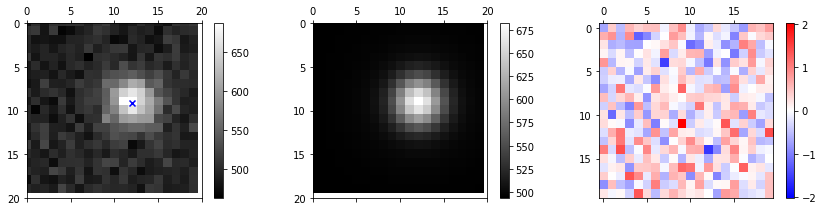

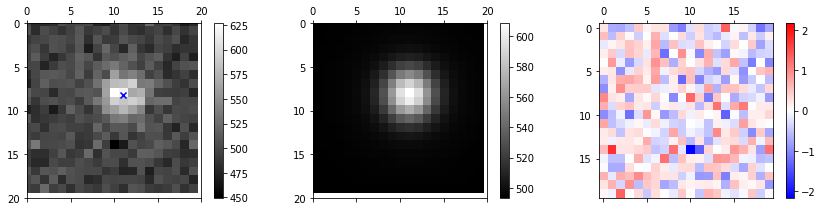

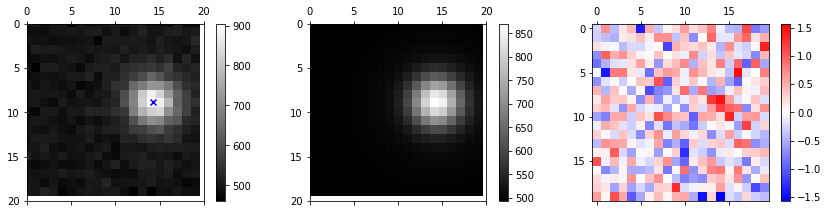

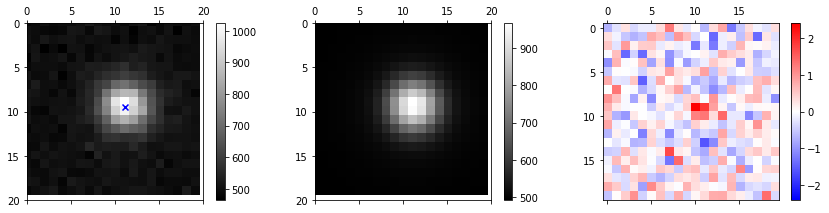

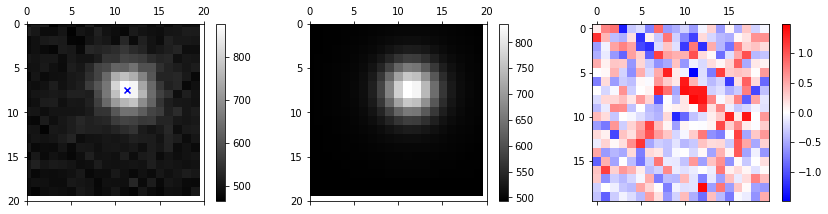

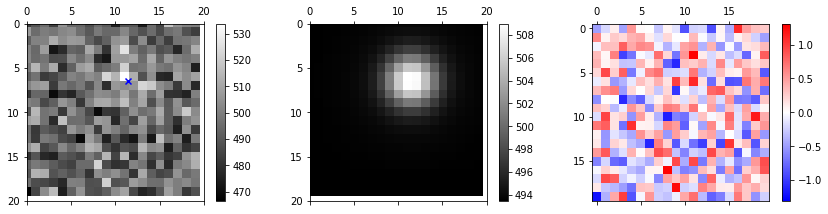

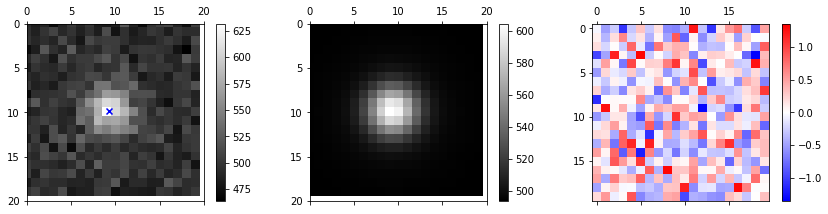

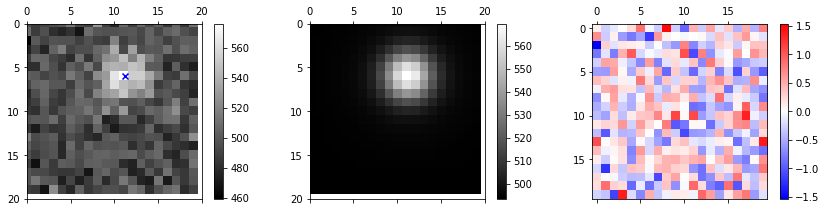

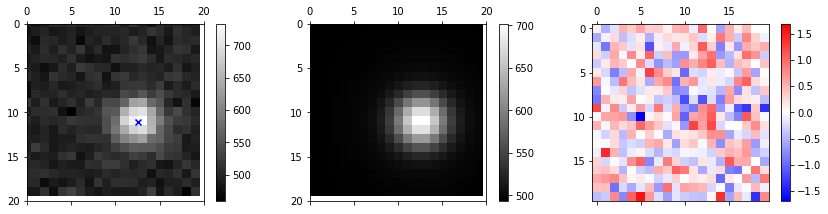

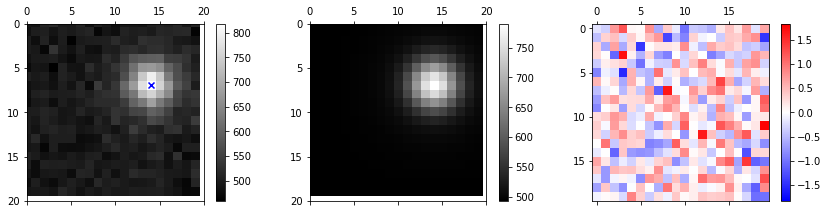

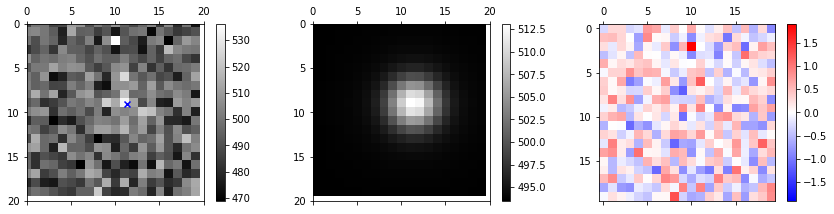

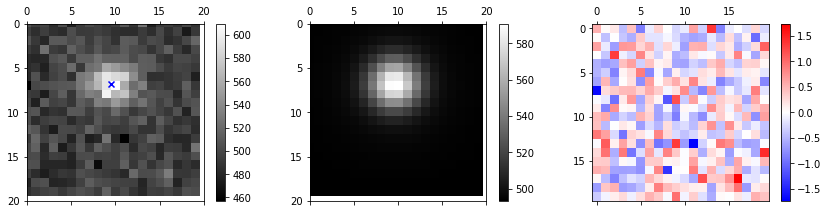

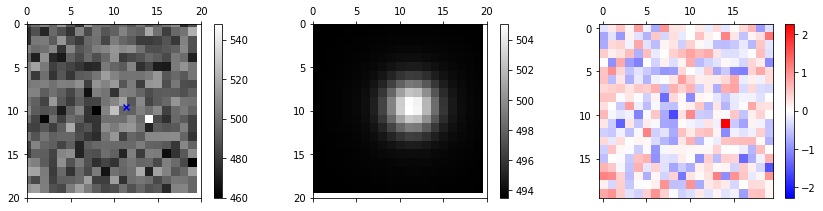

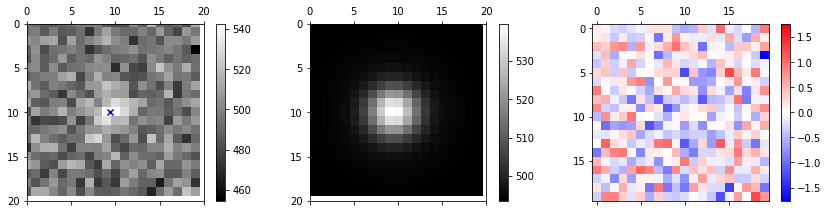

In [25]:
for i in range(psf_test_images.shape[0]): 

    f, axarr = plt.subplots(1, 3, figsize=(12, 3))
    
    im0 = plotting.plot_image(axarr[0], psf_test_images[i, 0])
    f.colorbar(im0, ax = axarr[0])
    
    
    im1 = plotting.plot_image(axarr[1], recon_mean[i, 0])
    f.colorbar(im1, ax = axarr[1])
    
    diff = (psf_test_images[i, 0] - recon_mean[i, 0]) / np.sqrt(recon_mean[i, 0])
    vmax = torch.max(torch.abs(diff))
    im3 = axarr[2].matshow(diff, 
                           cmap = plt.get_cmap('bwr'), 
                           vmax = vmax, vmin = -vmax)
    f.colorbar(im3, ax = axarr[2])
    
    plotting.plot_locations(est_locs[i:(i+1), :] * subimage_slen,
                            axarr[0], 
                            marker = 'x')
    
    f.tight_layout()

In [26]:
np.save('./psf/iband_psf_fitted.npy', 
        star_decoder.params.detach().numpy())

In [27]:
np.load('./psf/iband_psf_fitted.npy')

array([[ 1.22346507,  1.24712715,  2.4529863 ,  1.85989012, -1.21974602,
        -1.89163723]])

In [28]:
subimage_locs = np.array([x0_vec, x1_vec]).transpose()

In [29]:
np.save('./est_locs_i.npy', 
        est_locs * subimage_slen + subimage_locs)

In [30]:
i_psf = np.load('./psf/iband_psf_fitted.npy')
z_psf = np.load('./psf/zband_psf_fitted.npy')

In [31]:
np.save('./psf/ziband_psf_fitted.npy', 
        np.vstack([z_psf, i_psf]))

In [ ]:
# psf_params_file = './psf/zband_psf_gauss.npy'
                    
# tiler = decoder.Tiler(tile_slen, tile_slen)

# star_decoder_gauss = decoder.StarTileDecoder(tiler, 
#                                        n_bands = n_bands, 
#                                        psf_slen = psf_slen, 
#                                        psf_params_file = psf_params_file)